In [1]:
import sys
sys.path.append("../../..")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)
import utility

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)
import utility

In [4]:
df = pd.read_excel("../../../data/yeast_metadata.xlsx", sheet_name="unfiltered_gain")

In [5]:
# rearrange cols in df 
df = df[['Position', 'CHROM', 'REF', 'ALT', 'population_name', 'G70_ref_counts', 'accumulate_gain','G1410_ref_counts', 'G2640_ref_counts', 'G5150_ref_counts',
       'G7530_ref_counts', 'G10150_ref_counts', 'G70_alt_counts',
       'G1410_alt_counts', 'G2640_alt_counts', 'G5150_alt_counts',
       'G7530_alt_counts', 'G10150_alt_counts']]

In [6]:
data_all_copy = df.copy()
all_mutation = pd.DataFrame() # The all_mutation dataframe contain generation and population wise accumulated gain

for i in data_all_copy.columns[-6:]:
    new_df_tmp = pd.DataFrame()
    new_df = data_all_copy[data_all_copy.loc[:, i]!=0]
    new_df_tmp = new_df[["population_name", 'CHROM', 'Position', 'REF','ALT']]
    new_df_tmp.loc[:, "generation"] = i
    new_df_tmp.loc[:, "AG"] = new_df.loc[:, "accumulate_gain"]
    new_df_tmp.loc[:, "allele count"] = new_df.loc[:, i]
    all_mutation = pd.concat([all_mutation, new_df_tmp], axis = 0)
    
    
all_mutation.reset_index(inplace=True, drop=True)
# all_mutation['generation_number'] = all_mutation['generation'].str.extract(r'(\d+)').astype(int)
# for i in range(all_mutation.shape[0]):
    
#     if all_mutation.loc[i, "label"] in mutator_list:
#         all_mutation.loc[i, "mutator"] = "mutator"
#     if all_mutation.loc[i, "label"] in non_mutator_list:
#         all_mutation.loc[i, "mutator"] = "non mutator"

all_mutation.head()

,population_name,CHROM,Position,REF,ALT,generation,AG,allele count
0,P1C11,chrX,66,C,T,G70_alt_counts,6.067923,7
1,P1C11,chrX,69,T,A,G70_alt_counts,-4.705100,7
2,P1C11,chrX,73,C,T,G70_alt_counts,3.963808,7
3,P2B04,chrX,73,C,T,G70_alt_counts,3.963808,5
4,P1B02,chrX,74,T,C,G70_alt_counts,-2.479826,5


In [7]:
ann = pd.read_csv("../../../data/yeast_gene_annotations.tsv",
                  sep="\t", on_bad_lines='skip')
ann.head()

,Gene_ORF,Gene,ORF,SGDID,Essential_by_yeastmine,Essential_by_Liu2015,Essential_by_Giaever2002,featureType,briefDescription,description,functionSummary,phenotypeSummary,chromosome,start,end,orf_strand,go_ids,go_terms,go_types
0,GAS5,GAS5,YOL030W,S000005390,False,False,False,ORF,"1,3-beta-glucanosyltransferase","1,3-beta-glucanosyltransferase; has similarity...",NaN,NaN,chrXV,268187,269641,1,GO:0005576;GO:0005618;GO:0005783;GO:0006074;GO...,extracellular region;cell wall;endoplasmic ret...,cellular_component;cellular_component;cellular...
1,GAS4,GAS4,YOL132W,S000005492,False,False,False,ORF,"1,3-beta-glucanosyltransferase","1,3-beta-glucanosyltransferase; involved with ...",NaN,NaN,chrXV,71300,72715,1,GO:0000324;GO:0005618;GO:0005886;GO:0009277;GO...,fungal-type vacuole;cell wall;plasma membrane;...,cellular_component;cellular_component;cellular...
2,GAS2,GAS2,YLR343W,S000004335,False,False,False,ORF,"1,3-beta-glucanosyltransferase","1,3-beta-glucanosyltransferase; involved with ...",NaN,NaN,chrXII,816094,817761,1,GO:0000324;GO:0005618;GO:0005737;GO:0005886;GO...,fungal-type vacuole;cell wall;cytoplasm;plasma...,cellular_component;cellular_component;cellular...
3,SLC1,SLC1,YDL052C,S000002210,False,False,False,ORF,1-acyl-sn-glycerol-3-phosphate acyltransferase,1-acyl-sn-glycerol-3-phosphate acyltransferase...,NaN,NaN,chrIV,362672,363583,-1,GO:0003841;GO:0005783;GO:0005811;GO:0006629;GO...,1-acylglycerol-3-phosphate O-acyltransferase a...,molecular_function;cellular_component;cellular...
4,FAB1,FAB1,YFR019W,S000001915,False,False,False,ORF,1-phosphatidylinositol-3-phosphate 5-kinase,1-phosphatidylinositol-3-phosphate 5-kinase; v...,NaN,Non-essential gene; null mutant has defective ...,chrVI,184502,191338,1,GO:0000166;GO:0000285;GO:0000329;GO:0005524;GO...,nucleotide binding;1-phosphatidylinositol-3-ph...,molecular_function;molecular_function;cellular...


In [8]:
# replace in df Chrom in that chrmt with chrmito
ann['chromosome'] = ann['chromosome'].replace('chrmt', 'chrmito')

In [9]:
import pandas as pd

# Ensure `CHROM` and `chromosome` are in the same format
ann['chromosome'] = ann['chromosome'].str.lower()
all_mutation['CHROM'] = all_mutation['CHROM'].str.lower()


In [10]:
for i in range(all_mutation.shape[0]):

    chrom = all_mutation.loc[i, "CHROM"]

    pos = all_mutation.loc[i, "Position"]
    # pos = 268188
    # chrom = "chrxv"

    tmp = ann[(ann["chromosome"] == chrom) & (ann["start"] <= pos) & (pos <= ann["end"])]
    
    if tmp.shape[0]!=0:
        all_mutation.loc[i, "essential"] = tmp["Essential_by_Liu2015"].values[0]

    # else:
    #     all_mutation.loc[i, "essential"] = None



/tmp/ipykernel_409865/2849194644.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_mutation.loc[i, "essential"] = tmp["Essential_by_Liu2015"].values[0]


In [25]:
all_mutation["essential"].dropna().value_counts()

essential
False    209470
True       9661
Name: count, dtype: int64

In [14]:
all_mutation

,population_name,CHROM,Position,REF,ALT,generation,AG,allele count,essential
0,P1C11,chrx,66,C,T,G70_alt_counts,6.067923,7,NaN
1,P1C11,chrx,69,T,A,G70_alt_counts,-4.705100,7,NaN
2,P1C11,chrx,73,C,T,G70_alt_counts,3.963808,7,NaN
3,P2B04,chrx,73,C,T,G70_alt_counts,3.963808,5,NaN
4,P1B02,chrx,74,T,C,G70_alt_counts,-2.479826,5,NaN
...,...,...,...,...,...,...,...,...,...
500926,P3D10,chriv,1525964,C,T,G10150_alt_counts,8.835324,4,NaN
500927,P3D11,chriv,1525964,C,T,G10150_alt_counts,8.835324,2,NaN
500928,P3E08,chriv,1525964,C,T,G10150_alt_counts,8.835324,2,NaN
500929,P3F09,chriv,1525964,C,T,G10150_alt_counts,8.835324,6,NaN


##### Box plot of kGain vs generation

x: G70_alt_counts, p-value: 1.65e-17, Cohen's d: 4.75e-01
x: G1410_alt_counts, p-value: 2.20e-35, Cohen's d: 5.19e-01
x: G2640_alt_counts, p-value: 2.94e-27, Cohen's d: 3.13e-01
x: G5150_alt_counts, p-value: 6.18e-32, Cohen's d: 3.52e-01
x: G7530_alt_counts, p-value: 5.75e-26, Cohen's d: 2.39e-01
x: G10150_alt_counts, p-value: 2.30e-32, Cohen's d: 2.90e-01


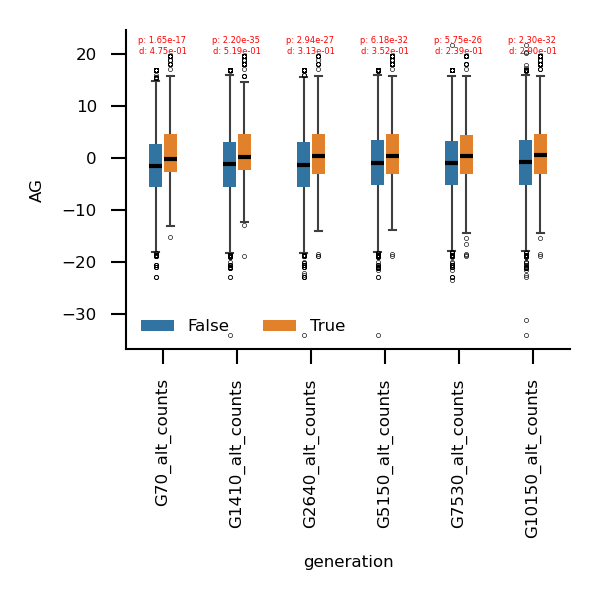

In [21]:
# Plot each score's cumulative sum separately
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(2.1, 2.1), dpi = 300)
ax = sns.boxplot(x='generation', y='AG', data=all_mutation, hue='essential', ax =ax, boxprops=dict(edgecolor="black", linewidth=0),flierprops=dict(marker='o', markeredgecolor='black'), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1}, gap = 0.1)
ax = utility.custom_figure_axis(ax=ax, fontsize=4, show_ticks = True, rotation=90)
ax = utility.return_box_with_p_effect_size(ax, data = all_mutation, x_columns = 'generation', y_columns = 'AG', group1_name = True, group2_name = False, y_pos = 20, hue_columns="essential", fontsize=2)

ax.legend(ncol = 2, frameon = False, fontsize=4)
plt.tight_layout()
# plt.savefig("yeast_esential.pdf", dpi = 300)